# Typical training data for ECG classifiers

## Notebook setup

In [1]:
import os
import configparser
from pathlib import Path
from typing import List, TypedDict
from enum import Enum

import wfdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#|include: false
# If the current working directory is the nbs/ folder, change to the project 
# root directory instead.

if Path.cwd().stem == "nbs":
    os.chdir(Path.cwd().parent)
print(f"The current working directory is {Path.cwd()}")

The current working directory is /Users/shaun/source/Thesis/PhysioNetChallenge2020


In [3]:
#|include: false
# Import configuration settings, like location of data directory.
config = configparser.ConfigParser()
if not Path("config.ini").exists():
    print("WARNING: Please generate a config.ini file by running scripts/get_datasets.py")
else:
    config.read("config.ini")
    data_dir = Path((config["datasets"]["path"])).expanduser()
    print(f"Datasets are located at {data_dir.resolve()}")

Datasets are located at /Users/shaun/source/Thesis/PhysioNetChallenge2020/data


## Dataset quickstart

***Table: Characteristics of 12-lead ECG recordings used for PhysioNet Challenge 2020***

| Dataset | Sampling frequency \[Hz\] | Recording length \[s\] | Notes |
|-|-|-|-|
| `cpsc`/`cpsc_extra` | 500 | 6 to 60 | Per HIPAA guidelines ages over 89 are removed |
| `incart` | 257 | 1800 | Holter recordings, annotations included |
| `ptb` | 1000 | ? |  |
| `ptbxl` | 500 | 10 |  |
| `georgia` | 500 | 10 | Southeastern US patient demographic |

Probably just use `ptbxl` and `georgia` for this project.


In [4]:
# Path to each training dataset

training_dir = data_dir / "challenge-2020" / "1.0.2" / "training"

georgia_dir = training_dir / "georgia"
cpsc_dir = training_dir / "cpsc_2018"
cpscextra_dir = training_dir / "cpsc_2018_extra"
ptb_dir = training_dir / "ptb"
ptbxl_dir = training_dir / "ptb-xl"
incart_dir = training_dir / "st_petersburg_incart"

`wfdb.rdheader` to read metadata about record.

`wfdb.rdrecord` to read signal data.

In [5]:
# record = wfdb.rdheader(georgia_dir / "g1" / "E00001")
# record = wfdb.rdheader(ptbxl_dir / "g1" / "HR00001")

record = wfdb.rdrecord(ptbxl_dir / "g1" / "HR00001")

In [6]:
# Signal data as pandas dataframe
signals = record.to_dataframe()
signals.head()

,I,II,III,aVR,aVL,aVF,V1,V2,V3,V4,V5,V6
0 days 00:00:00,-0.115,-0.05,0.065,0.082,-0.09,0.007,-0.065,-0.04,-0.005,-0.035,-0.035,-0.075
0 days 00:00:00.002000,-0.115,-0.05,0.065,0.082,-0.09,0.007,-0.065,-0.04,-0.005,-0.035,-0.035,-0.075
0 days 00:00:00.004000,-0.115,-0.05,0.065,0.082,-0.09,0.007,-0.065,-0.04,-0.005,-0.035,-0.035,-0.075
0 days 00:00:00.006000,-0.115,-0.05,0.065,0.082,-0.09,0.007,-0.065,-0.04,-0.005,-0.035,-0.035,-0.075
0 days 00:00:00.008000,-0.115,-0.05,0.065,0.082,-0.09,0.007,-0.065,-0.04,-0.005,-0.035,-0.035,-0.075


In [7]:
# Each individual signal is a `Series` object
signals.I.head()

0 days 00:00:00          -0.115
0 days 00:00:00.002000   -0.115
0 days 00:00:00.004000   -0.115
0 days 00:00:00.006000   -0.115
0 days 00:00:00.008000   -0.115
Freq: 2ms, Name: I, dtype: float64

In [8]:
# Units for each channel (should all be in mV)
record.units

['mv', 'mv', 'mv', 'mv', 'mv', 'mv', 'mv', 'mv', 'mv', 'mv', 'mv', 'mv']

In [9]:
# Sampling frequency (Hz)
record.fs

# If not 500 Hz, resample.
# https://pandas.pydata.org/docs/getting_started/intro_tutorials/09_timeseries.html#resample-a-time-series-to-another-frequency

500

In [10]:
# Length of recording (should always be 10 s)
print(f"Length (s): {len(record.to_dataframe()) * (1/record.fs)}")

Length (s): 10.0


## Medical terminologies and codes

SNOMED-CT codes are provided as labels for each training dataset.

Dx stands for diagnosis?

In [11]:
record = wfdb.rdheader(ptbxl_dir / "g1" / "HR00001")
record.comments # [2] is the diagnosis comment

['Age: 56',
 'Sex: Female',
 'Dx: 251146004,426783006',
 'Rx: Unknown',
 'Hx: Unknown',
 'Sx: Unknown']

We could use a package such as [PyMedTermino2](https://owlready2.readthedocs.io/en/latest/pymedtermino2.html) to access medical terminologies from a UMLS database. 
However, we only need a very small subset of diagnosis codes. We'll just keep a 
Python dictionary of ~10 codes.

In [12]:
diagnosis_codes = {
    # Sinus rhythm
    426177001:  "Sinus bradycardia",
    426783006:  "Normal sinus rhythm",
    427084000:  "Sinus tachycardia",
    427393009:  "Sinus arrhythmia",

    # Conduction pathway (specifically right bundle branch)
    713427006:  "Complete right bundle branch block",
    713426002:  "Incomplete right bundle branch block",

    # T-wave (should be for each lead)
    164934002:  "T-wave abnormal",
    59931005:   "T-wave inversion",
}

In [13]:
# 

class SinusRhythmFinding(Enum):
    bradycardia = 0
    normal = 1
    tachycardia = 2
    arrhythmia = 3      # Broad description, can overlap with brady/tachy.

class RBBBFinding(Enum):
    none = 0
    incomplete = 1
    complete = 2

class TWaveFinding(Enum):
    none = 0
    inversion = 1
    other = 2

def classify_rbbb_finding():
    pass

In [14]:
def extract_snomed_ct_codes_from_comment(dx_comment: str) -> List[int]:
    """Returns a list of SNOMED-CT codes related to ECG diagnoses.

    Assumes that `dx_comment` is in the form "Dx: code1,code2,etc."

    Example usage:
    ```
    record = wfdb.rdheader(ptbxl_dir / "g1" / "HR00001")
    dx_comment = record.comments[2]
    dx_comment
    > 'Dx: 251146004,426783006'

    extract_snomed_ct_codes_from_comment(dx_comment)
    > [251146004, 426783006]
    ```
    """
    # Just the diagnosis codes (ignore the "Dx: " prefix)
    comment = dx_comment.split(': ')[1]

    # Split codes into list, convert to integers
    code_text = comment.split(',')
    return list(map(int, code_text))


In [15]:
# Example usage
extract_snomed_ct_codes_from_comment(record.comments[2])

[251146004, 426783006]

## Extract demographics and labels for population analysis

In [16]:
def get_all_records(dataset_dir: Path) -> List[Path]:
    """Returns a list of every record in a PhysioNet Challenge 2020 dataset
    """
    records = []
    # For every folder (e.g. g1/, g2/, etc.)
    for folder in dataset_dir.iterdir():
        if folder.is_dir():
            # print(f"Searching folder: {folder}")
            # For every record (each record has a `.hea` header file)
            for file in folder.iterdir():
                if file.suffix == '.hea':
                    records.append( folder / file.stem )
    # print(f"Found {len(records)} records")
    return records

In [17]:
class DemographicInfo(TypedDict):
    age: int
    sex: str

def generate_labels_table(records: List[Path]) -> pd.DataFrame:
    data = []
    for record in records:
        header = wfdb.rdheader(record)

        # Extract demographic info
        age_str = header.comments[0].split(': ')[1]
        age = int( age_str ) if age_str.isnumeric() else None
        sex = header.comments[1].split(': ')[1]
        demographics: DemographicInfo = {
            'age': age,
            'sex': sex,
        }

        # Filter out some records by age (e.g. 300 year old is a typo, kids)
        if not age == None:
            if (age > 90) or (age < 18):
                continue
        
        # Extract ECG diagnostic info (labels)
        diagnoses = extract_snomed_ct_codes_from_comment( header.comments[2] )
        relevant_findings = {
            # Sinus rhythm
            "426177001":  False,  # "Sinus bradycardia",
            "426783006":  False,  # "Normal sinus rhythm",
            "427084000":  False,  # "Sinus tachycardia",
            "427393009":  False,  # "Sinus arrhythmia",

            # Conduction pathway (specifically right bundle branch)
            "713427006":  False,  # "Complete right bundle branch block",
            "713426002":  False,  # "Incomplete right bundle branch block",

            # T-wave (should be for each lead)
            "164934002":  False,  # "T-wave abnormal",
            "59931005":   False,  # "T-wave inversion",
        }
        for code in diagnoses:
            if code in diagnosis_codes:
                relevant_findings[f"{code}"] = True
        
        # Save data
        data.append( {**demographics, **relevant_findings} )

    return pd.DataFrame(data)

In [18]:
# Get demographics and labels for every dataset used to train DSAIL_SNU model

ptbxl_records = get_all_records(ptbxl_dir)
georgia_records = get_all_records(georgia_dir)
cpsc_records = get_all_records(cpsc_dir)
cpscextra_records = get_all_records(cpscextra_dir)

ptbxl_df = generate_labels_table(ptbxl_records)
georgia_df = generate_labels_table(georgia_records)
cpsc_df = generate_labels_table(cpsc_records)
cpscextra_df = generate_labels_table(cpscextra_records)

In [19]:
cpscextra_df.head()

,age,sex,426177001,426783006,427084000,427393009,713427006,713426002,164934002,59931005
0,24.0,Male,False,False,False,False,False,False,False,False
1,72.0,Male,False,False,True,False,False,False,False,False
2,84.0,Female,False,False,False,False,False,False,False,False
3,80.0,Male,False,False,False,False,False,False,False,False
4,55.0,Female,False,False,False,False,False,False,False,False


### Data integrity issues

Issue 1: Impossible age recorded. Probably a typo, not many.

In [20]:
# Note: There seem to be errors in some of the comments. 
# Like this 300 year old lady.
header = wfdb.rdheader(ptbxl_records[248])
header.comments

['Age: 300',
 'Sex: Female',
 'Dx: 164873001,164934002,426783006',
 'Rx: Unknown',
 'Hx: Unknown',
 'Sx: Unknown']

Issue 2: No age recorded. Not a huge issue, less than 200 records across both datasets.

In [21]:
# Some records don't have an age recorded. Represented with "NaN".
header = wfdb.rdheader("data/challenge-2020/1.0.2/training/ptb-xl/g6/HR05040")
header.comments

['Age: NaN',
 'Sex: Female',
 'Dx: 39732003,426783006,429622005,445118002',
 'Rx: Unknown',
 'Hx: Unknown',
 'Sx: Unknown']

In [22]:
# Some examples of NaN ages
ptbxl_df[ptbxl_df.age.isna()].head()

,age,sex,426177001,426783006,427084000,427393009,713427006,713426002,164934002,59931005
364,NaN,Female,False,True,False,False,False,False,False,False
507,NaN,Male,False,False,False,False,False,False,False,False
570,NaN,Female,False,True,False,False,False,False,False,False
649,NaN,Female,False,False,False,False,False,False,False,False
992,NaN,Male,False,True,False,False,False,False,False,False


In [23]:
len(ptbxl_df[ptbxl_df.age.isna()])

89

In [24]:
len(georgia_df[georgia_df.age.isna()])

77

## Distributions

TODO: seaborn plot of age distribution. Also sex.

In [25]:
# Bradycardia
sum(georgia_df["426177001"] == True)

1675

In [26]:
# Normal sinus rhythm
sum(georgia_df["426783006"] == True)

1752

In [27]:
# Tachycardia
sum(georgia_df["427084000"] == True)

1261

In [28]:
# Arrhythmia
sum(georgia_df["427393009"] == True)

455

In [29]:
# Absence of sinus rhythm finding (Assume normal rhythm?)
sum( (georgia_df["426177001"] == False) * (georgia_df["427084000"] == False) * (georgia_df["427393009"] == False) * (georgia_df["426783006"] == False))

5318

In [30]:
ptbxl_df.groupby("sex").describe()

# TODO: Remove paediatric cases. Either below 18 (UK) or below 21 (US).
# TODO: Remove obvious outlier ages. HIPAA guidelines say to remove ages over 89.

age                                                    
          count       mean        std   min   25%   50%   75%   max
sex                                                                
Female  10166.0  60.708538  17.692363  18.0  50.0  63.0  75.0  89.0
Male    11245.0  59.019031  15.141418  18.0  50.0  61.0  69.0  89.0

In [31]:
georgia_df.groupby("sex").describe()

age                                                     
         count       mean        std   min   25%   50%    75%   max
sex                                                                
Female  4750.0  60.280000  16.135244  20.0  50.0  62.0  72.00  89.0
Male    5514.0  60.689699  14.769454  18.0  52.0  62.0  71.75  89.0

Text(0.5, 1.0, 'Age distribution (georgia)')

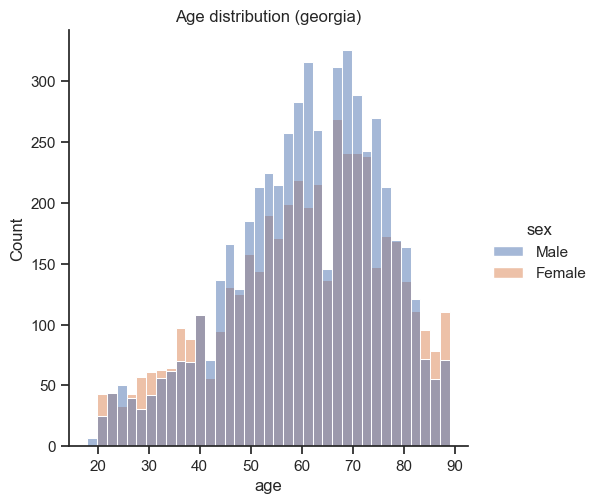

In [32]:
sns.set_theme(style="ticks")

sns.displot(georgia_df, x="age", hue="sex")
plt.title("Age distribution (georgia)")

Text(0.5, 1.0, 'Estimated PDF for georgia dataset')

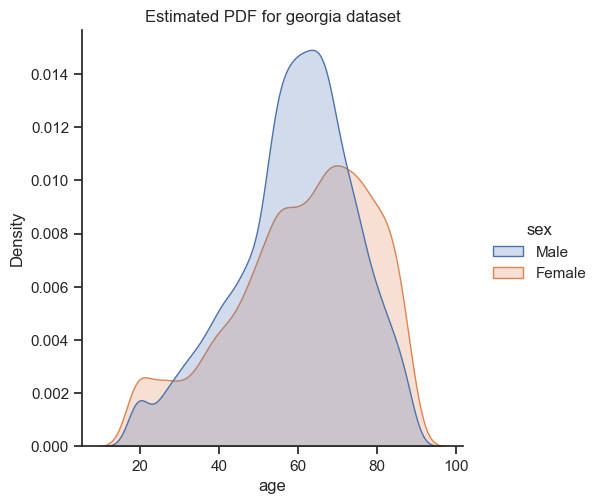

In [33]:
sns.set_theme(style="ticks")

sns.displot(ptbxl_df, x="age", hue="sex", kind="kde", fill=True, bw_adjust=1)
plt.title("Estimated PDF for georgia dataset")

## Poster plots

In [34]:
len(ptbxl_df) + len(georgia_df)

31841

In [35]:
big_df = pd.DataFrame(data=ptbxl_df)

In [36]:
big_df = pd.concat([ptbxl_df, georgia_df, cpsc_df, cpscextra_df], ignore_index=True)

In [37]:
big_df.head()

,age,sex,426177001,426783006,427084000,427393009,713427006,713426002,164934002,59931005
0,22.0,Male,False,True,False,True,False,False,False,False
1,52.0,Male,True,False,False,False,False,False,False,False
2,49.0,Female,False,True,False,False,False,False,False,False
3,50.0,Male,False,True,False,False,False,False,False,False
4,43.0,Male,False,True,False,False,False,False,False,False


In [44]:
big_df.describe()

,age
count,41653.000000
mean,60.443233
std,16.257737
min,18.000000
25%,51.000000
50%,62.000000
75%,73.000000
max,89.000000


Text(0.5, 1.0, 'Patient demographics of source domain')

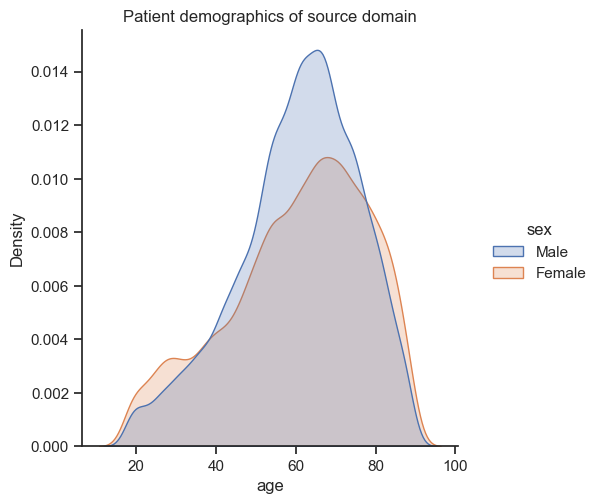

In [38]:
sns.displot(big_df, x="age", hue="sex", kind="kde", fill=True, bw_adjust=1)
plt.title("Patient demographics of source domain")

In [39]:
list(map(str, diagnosis_codes.keys()))

['426177001',
 '426783006',
 '427084000',
 '427393009',
 '713427006',
 '713426002',
 '164934002',
 '59931005']

In [40]:
sns.catplot?

Signature:
sns.catplot(
    data=None,
    *,
    x=None,
    y=None,
    hue=None,
    row=None,
    col=None,
    kind='strip',
    estimator='mean',
    errorbar=('ci', 95),
    n_boot=1000,
    seed=None,
    units=None,
    weights=None,
    order=None,
    hue_order=None,
    row_order=None,
    col_order=None,
    col_wrap=None,
    height=5,
    aspect=1,
    log_scale=None,
    native_scale=False,
    formatter=None,
    orient=None,
    color=None,
    palette=None,
    hue_norm=None,
    legend='auto',
    legend_out=True,
    sharex=True,
    sharey=True,
    margin_titles=False,
    facet_kws=None,
    ci=<deprecated>,
    **kwargs,
)
Docstring:
Figure-level interface for drawing categorical plots onto a FacetGrid.

This function provides access to several axes-level functions that
show the relationship between a numerical and one or more categorical
variables using one of several visual representations. The `kind`
parameter selects the underlying axes-level function to us

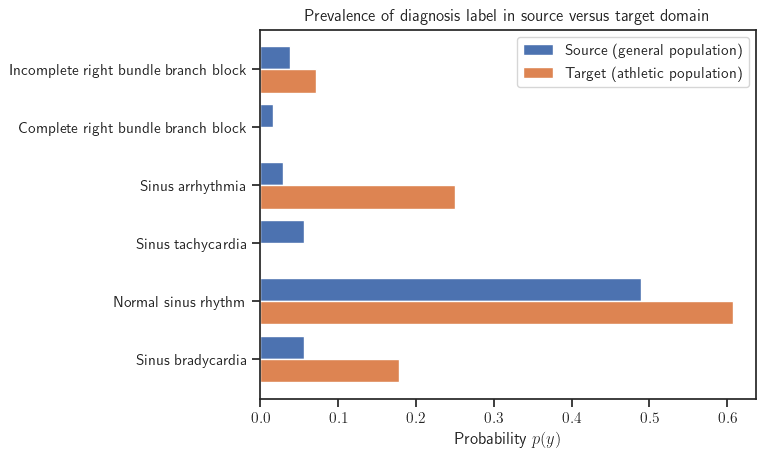

In [41]:
diagnosis_codes = {
    # Sinus rhythm
    426177001:  "Sinus bradycardia",
    426783006:  "Normal sinus rhythm",
    427084000:  "Sinus tachycardia",
    427393009:  "Sinus arrhythmia",

    # Conduction pathway (specifically right bundle branch)
    713427006:  "Complete right bundle branch block",
    713426002:  "Incomplete right bundle branch block",

    # # T-wave (should be for each lead)
    # 164934002:  "T-wave abnormal",
    # 59931005:   "T-wave inversion",
}

labels = list(diagnosis_codes.values())
N = len(big_df)
prevalence = []
for code in map(str, diagnosis_codes.keys()):
    count = sum(big_df[code] == True)
    prevalence.append( count / N )

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})
sns.set_theme(style="ticks")
fig, ax = plt.subplots()
# fig = plt.figure()
# https://stackoverflow.com/questions/10369681/how-to-plot-bar-graphs-with-same-x-coordinates-side-by-side-dodged

ax.barh(y=labels, width=prevalence, height=.4, align='edge', label="Source (general population)")
norwegian_counts = [5,17,0,7,0,2]
norwegian_prevalence = np.array(norwegian_counts) / 28
ax.barh(y=labels, width=norwegian_prevalence, height=-.4, align='edge', label="Target (athletic population)")
ax.set_xlabel("Probability $p(y)$")
ax.set_title("Prevalence of diagnosis label in source versus target domain")
ax.legend()

<Axes: xlabel='age', ylabel='Count'>

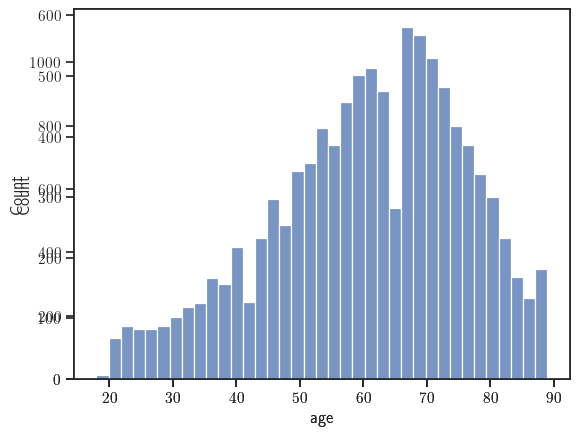

In [42]:
sns.set_theme(style="ticks")
# fig, ax = plt.subplots()
fig = plt.figure()

# ax = ptbxl_df.plot.kde()
ax1 = fig.add_subplot(111)
sns.histplot(ptbxl_df, x="age", ax=ax1)
# sns.histplot(georgia_df, x="age", kind="kde", fill=True, bw_adjust=1)

ax2 = fig.add_subplot(111)
sns.histplot(georgia_df, x="age", ax=ax2)

In [43]:
sns.histplot?

Signature:
sns.histplot(
    data=None,
    *,
    x=None,
    y=None,
    hue=None,
    weights=None,
    stat='count',
    bins='auto',
    binwidth=None,
    binrange=None,
    discrete=None,
    cumulative=False,
    common_bins=True,
    common_norm=True,
    multiple='layer',
    element='bars',
    fill=True,
    shrink=1,
    kde=False,
    kde_kws=None,
    line_kws=None,
    thresh=0,
    pthresh=None,
    pmax=None,
    cbar=False,
    cbar_ax=None,
    cbar_kws=None,
    palette=None,
    hue_order=None,
    hue_norm=None,
    color=None,
    log_scale=None,
    legend=True,
    ax=None,
    **kwargs,
)
Docstring:
Plot univariate or bivariate histograms to show distributions of datasets.

A histogram is a classic visualization tool that represents the distribution
of one or more variables by counting the number of observations that fall within
discrete bins.

This function can normalize the statistic computed within each bin to estimate
frequency, density or probability mas